# Cell Type

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
from tqdm import tqdm_notebook
import tqdm


# helper functions
def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle2mask(mask_rle, shape):
    """
    mask_rle: run-length as string formatted (start length)
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in
                       (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def rle_decode(mask_rle: str = "", shape: tuple = (1400, 2100)):
    """Source: https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools"""
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order="F")

def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """Source: https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools"""
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)
    for idx, label in enumerate(encoded_masks.values):
        try:
            mask = rle_decode(label)
        except:
            mask = np.zeros((1400, 2100))
        masks[:, :, idx] = mask         
    return masks

def get_img(name):
    img = cv2.imread(name)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8') 
    plt.figure(figsize = (4,2))
    return plt.imshow(a, **kwargs)

def visualize(image, mask, original_image=None, original_mask=None, gray=True):
    """Source: https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools"""
    fontsize = 14
    class_dict = {0: "Fish", 1: "Flower", 2: "Gravel", 3: "Sugar"}    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        if gray:
            ax[0].imshow(image, cmap='gray')
        else:    
            ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f"Mask {class_dict[i]}", fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title("Original image", fontsize=fontsize)

        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f"Original mask {class_dict[i]}", fontsize=fontsize)

        ax[1, 0].imshow(image)
        ax[1, 0].set_title("Transformed image", fontsize=fontsize)

        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(
                f"Transformed mask {class_dict[i]}", fontsize=fontsize
            )


In [2]:
out_dir_img = './understanding_cloud_organization/resized_images_and_masks/resized_train_imgs'

ori_size = (1400, 2100) # (height, width)
new_size = (384, 576) # (height, width)

interpolation = cv2.INTER_CUBIC

  0%|                                                                       | 0/5546 [00:00<?, ?it/s, file=none]


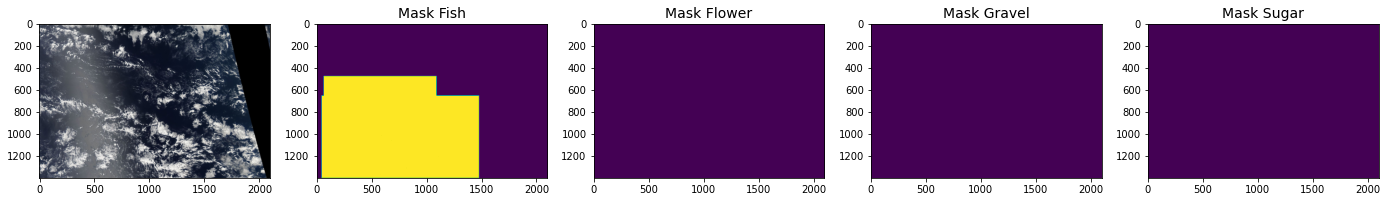

In [4]:
train_df = pd.read_csv(f"understanding_cloud_organization/train.csv")
train_df["label"] = train_df["Image_Label"].apply(lambda x: x.split("_")[1])
train_df["im_id"] = train_df["Image_Label"].apply(lambda x: x.split("_")[0])


train_images_dir = os.path.join(f"understanding_cloud_organization/train_images")

# Double checking segmentation with visualisation
for file in tqdm.tqdm(os.listdir(train_images_dir), postfix={"file":"none"}):
    image = get_img(os.path.join(train_images_dir, file))
    mask = make_mask(train_df, file)
    visualize(image, mask)
    break
    
    

#### Where will we store all the resized content?

In [17]:
try:
    os.mkdir('./understanding_cloud_organization/resized_images_and_masks')
except OSError as error:  
    print(error) 

[Errno 17] File exists: './understanding_cloud_organization/resized_images_and_masks'


In [16]:
# resize the mask after extracting it as a numpy array
for idx, row in train_df.iterrows():
    encodedpixels = row[1]
    if encodedpixels is not np.nan:
        mask = rle2mask(encodedpixels, shape=ori_size[::-1])
        mask = cv2.resize(mask, new_size[::-1], interpolation=interpolation)

        rle = mask2rle(mask)
        train_df.at[idx, 'EncodedPixels'] = rle
        
# make the directory to store new csv        
out_dir_masks = './understanding_cloud_organization/resized_images_and_masks/resized_train_masks'

try:
    os.mkdir(out_dir_masks)
except OSError as error:  
    print(error) 
    
# write segs to new csv after resize   
out_csv = out_dir_masks + '_'+str(new_size[0])+'_'+str(new_size[1])+'.csv'
train_df.to_csv(out_csv, index=False)
        

[Errno 17] File exists: './understanding_cloud_organization/resized_images_and_masks/resized_train_masks'


In [18]:
# Then we resize the images as well so they match the masks!

dst_path = out_dir_img + '_'+str(new_size[0])+'_'+str(new_size[1])

try:
    os.mkdir(dst_path)
except OSError as error: # if it already exists?
    print(error) 

for image_file in tqdm_notebook(os.listdir(train_images_dir)):
    img = cv2.imread(os.path.join(train_images_dir, image_file))
    img = cv2.resize(img, new_size[::-1], interpolation=interpolation)
    dst = os.path.join(dst_path, image_file)
    cv2.imwrite(dst, img)

/home/Munachiso.Nwadike/anaconda3/envs/cv_pipeline/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/5546 [00:00<?, ?it/s]

  0%|                                                                       | 0/5546 [00:00<?, ?it/s, file=none]


FILE NAME: 10ed865.jpg ./understanding_cloud_organization/resized_images_and_masks/resized_train_imgs_384_576
./understanding_cloud_organization/resized_images_and_masks/resized_train_imgs_384_576/10ed865.jpg
IMAGE SHP: 10ed865.jpg (384, 576, 3) <class 'numpy.ndarray'>


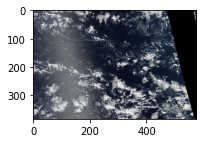

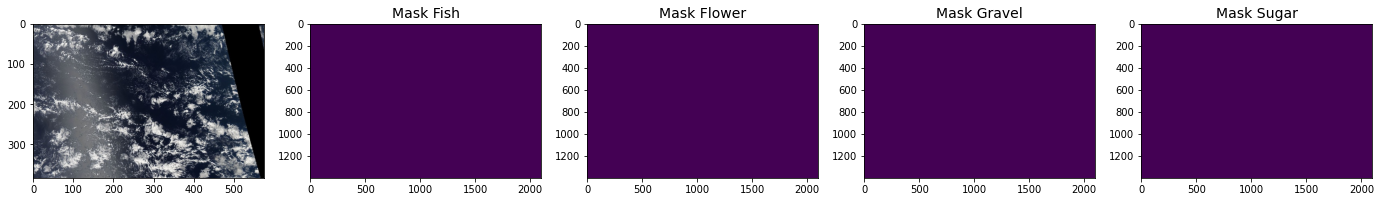

In [19]:
train_df_resized = pd.read_csv(out_csv)
train_df_resized["label"] = train_df_resized["Image_Label"].apply(lambda x: x.split("_")[1])
train_df_resized["im_id"] = train_df_resized["Image_Label"].apply(lambda x: x.split("_")[0])


# Double checking segmentation with visualisation
for file in tqdm.tqdm(os.listdir(dst_path), postfix={"file":"none"}):
    print("FILE NAME:", file, dst_path)
    print(os.path.join(dst_path, file))
    
    image = get_img(os.path.join(dst_path, file))
    print("IMAGE SHP:", file, image.shape, type(image))
    cv2_imshow(image)
    masks = make_mask(train_df_resized, file)
    visualize(image, masks)
    break        